In [1]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.preprocessing.text import Tokenizer, one_hot
from keras.optimizers import RMSprop
#from google.colab import drive
import numpy as np


import numpy as np
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

C:\Users\nikhi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
with open("t.txt","w")as f:
  f.write("hello")
data=pd.read_csv("piano_train_30.csv")

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,next_note
0,55,79,62,86,62,86,62,86,62,86,...,84,62,86,63,87,65,89,62,86,63
1,86,62,86,62,86,62,86,62,86,62,...,63,87,65,89,62,86,63,87,62,86
2,62,86,62,86,62,86,62,86,62,86,...,89,62,86,63,87,62,86,60,84,60
3,86,62,86,62,86,62,86,60,84,58,...,63,87,62,86,60,84,60,84,58,82
4,62,86,62,86,60,84,58,82,60,84,...,86,60,84,60,84,58,82,58,82,56


In [4]:
sub_sequences= data.iloc[:,:30].values
next_steps=data.iloc[:,30].values

In [5]:
len_notes=88
maxlen=30

X = np.zeros((len(sub_sequences), maxlen, len_notes), dtype=np.uint8 )
Y = np.zeros((len(sub_sequences), len_notes), dtype=np.uint8)
for i, seq in enumerate(sub_sequences):
    #print(seq)
    for t, note in enumerate(seq):
        X[i, t, note-21] = 1
        Y[i, note-21] = 1
print("x shape:",np.array(X).shape)
             

x shape: (76187, 30, 88)


In [6]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.preprocessing.text import Tokenizer, one_hot
from keras.optimizers import RMSprop
#from google.colab import drive
import numpy as np
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop
from keras import backend as K

char_rnn = Sequential()
char_rnn.add(LSTM(32, input_shape=(maxlen, 88)))
char_rnn.add(Dense(88,activation="softmax"))

In [7]:

#char_rnn.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01),metrics=["acc"])
#char_rnn.fit(X,Y, epochs=50, batch_size=512)

In [8]:
## LSTM
len_notes=88


maxlen=30

X = np.zeros((len(sub_sequences), maxlen, len_notes), dtype=np.uint8 )
Y2 = np.zeros((maxlen, len(sub_sequences),  len_notes), dtype=np.uint8)
for i, seq in enumerate(sub_sequences):
    #print(seq)
    for t, note in enumerate(seq):
        

        if t>0:
            X[i, t, note-21] = 1
            Y2[t-1, i, note-21] = 1
print("x shape:",np.array(X).shape)
print("y2 shape:",np.array(Y2).shape)

x shape: (76187, 30, 88)
y2 shape: (30, 76187, 88)


In [12]:
n_a = 64 
n_values=88
reshapor = Reshape((1, 88))                        # Used in Step 2.B of djmodel(), below
LSTM_cell = LSTM(n_a,return_state=True)         # Used in Step 2.C
densor = Dense(n_values, activation='softmax')     # Used in Step 2.D

In [13]:


# GRADED FUNCTION: djmodel

def djmodel(Tx, n_a, n_values):
    """
    Implement the model
    
    Arguments:
    Tx -- length of the sequence in a corpus
    n_a -- the number of activations used in our model
    n_values -- number of unique values in the music data 
    
    Returns:
    model -- a keras model with the 
    """
    
    # Define the input of your model with a shape 
    X = Input(shape=(Tx, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    
    ### START CODE HERE ### 
    # Step 1: Create empty list to append the outputs while you iterate (≈1 line)
    outputs = []
    
    # Step 2: Loop
    for t in range(Tx):
        
        # Step 2.A: select the "t"th time step vector from X. 
        x = Lambda(lambda x: X[:,t,:])(X) #Wraps arbitrary expression as a Layer object.
        # Step 2.B: Use reshapor to reshape x to be (1, n_values) (≈1 line)
        x =reshapor(x)    
        # Step 2.C: Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        #LSTM_cell(x, initial_state=[a, c])
        # Step 2.D: Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)
        # Step 2.E: add the output to "outputs"
        outputs.append(out)
        
    # Step 3: Create model instance
    model = Model(inputs = [X,a0,c0],outputs = outputs)
    
    ### END CODE HERE ###
    
    return model
model = djmodel(Tx = 30 , n_a = 64, n_values = 88)

In [14]:
X.shape

(76187, 30, 88)

In [15]:
opt = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
m = 76187
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

history=model.fit([X, a0, c0], list(Y2), batch_size=128,epochs=30)

Epoch 1/30
76187/76187 [==============================] - 57s 748us/step - loss: 66.0823 - dense_2_loss: 0.0000e+00 - dense_2_acc: 0.0566 - dense_2_acc_1: 0.1776 - dense_2_acc_2: 0.2196 - dense_2_acc_3: 0.2701 - dense_2_acc_4: 0.3385 - dense_2_acc_5: 0.3916 - dense_2_acc_6: 0.4317 - dense_2_acc_7: 0.4400 - dense_2_acc_8: 0.4499 - dense_2_acc_9: 0.4557 - dense_2_acc_10: 0.4602 - dense_2_acc_11: 0.4559 - dense_2_acc_12: 0.4628 - dense_2_acc_13: 0.4624 - dense_2_acc_14: 0.4580 - dense_2_acc_15: 0.4622 - dense_2_acc_16: 0.4623 - dense_2_acc_17: 0.4572 - dense_2_acc_18: 0.4641 - dense_2_acc_19: 0.4624 - dense_2_acc_20: 0.4586 - dense_2_acc_21: 0.4633 - dense_2_acc_22: 0.4636 - dense_2_acc_23: 0.4579 - dense_2_acc_24: 0.4608 - dense_2_acc_25: 0.4613 - dense_2_acc_26: 0.4594 - dense_2_acc_27: 0.4600 - dense_2_acc_28: 0.4629 - dense_2_acc_29: 0.0000e+00
Epoch 2/30
76187/76187 [==============================] - 38s 497us/step - loss: 57.3010 - dense_2_loss: 0.0000e+00 - dense_2_acc: 0.0581 - de

76187/76187 [==============================] - 37s 487us/step - loss: 53.1911 - dense_2_loss: 0.0000e+00 - dense_2_acc: 0.0582 - dense_2_acc_1: 0.1818 - dense_2_acc_2: 0.2351 - dense_2_acc_3: 0.3017 - dense_2_acc_4: 0.3919 - dense_2_acc_5: 0.4669 - dense_2_acc_6: 0.5199 - dense_2_acc_7: 0.5428 - dense_2_acc_8: 0.5568 - dense_2_acc_9: 0.5706 - dense_2_acc_10: 0.5770 - dense_2_acc_11: 0.5779 - dense_2_acc_12: 0.5881 - dense_2_acc_13: 0.5934 - dense_2_acc_14: 0.5896 - dense_2_acc_15: 0.5981 - dense_2_acc_16: 0.6012 - dense_2_acc_17: 0.5961 - dense_2_acc_18: 0.6023 - dense_2_acc_19: 0.6032 - dense_2_acc_20: 0.5965 - dense_2_acc_21: 0.6015 - dense_2_acc_22: 0.6043 - dense_2_acc_23: 0.5968 - dense_2_acc_24: 0.6027 - dense_2_acc_25: 0.6039 - dense_2_acc_26: 0.5956 - dense_2_acc_27: 0.6023 - dense_2_acc_28: 0.6026 - dense_2_acc_29: 2.6251e-05
Epoch 15/30
76187/76187 [==============================] - 37s 492us/step - loss: 53.1360 - dense_2_loss: 0.0000e+00 - dense_2_acc: 0.0582 - dense_2_acc_

76187/76187 [==============================] - 38s 492us/step - loss: 52.7334 - dense_2_loss: 0.0000e+00 - dense_2_acc: 0.0582 - dense_2_acc_1: 0.1829 - dense_2_acc_2: 0.2346 - dense_2_acc_3: 0.3029 - dense_2_acc_4: 0.3923 - dense_2_acc_5: 0.4689 - dense_2_acc_6: 0.5209 - dense_2_acc_7: 0.5443 - dense_2_acc_8: 0.5588 - dense_2_acc_9: 0.5737 - dense_2_acc_10: 0.5808 - dense_2_acc_11: 0.5805 - dense_2_acc_12: 0.5915 - dense_2_acc_13: 0.5976 - dense_2_acc_14: 0.5939 - dense_2_acc_15: 0.6025 - dense_2_acc_16: 0.6061 - dense_2_acc_17: 0.6010 - dense_2_acc_18: 0.6085 - dense_2_acc_19: 0.6093 - dense_2_acc_20: 0.6026 - dense_2_acc_21: 0.6089 - dense_2_acc_22: 0.6101 - dense_2_acc_23: 0.6024 - dense_2_acc_24: 0.6091 - dense_2_acc_25: 0.6107 - dense_2_acc_26: 0.6018 - dense_2_acc_27: 0.6070 - dense_2_acc_28: 0.6085 - dense_2_acc_29: 2.6251e-0529s - loss: 52.6391 -
Epoch 28/30
76187/76187 [==============================] - 37s 483us/step - loss: 52.7128 - dense_2_loss: 0.0000e+00 - dense_2_acc: 

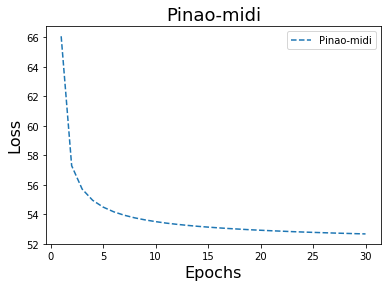

In [21]:
# --- Plotting data/training model ---
import matplotlib.pyplot as plt

# Get loss function
loss = history.history['loss']
#loss=[0]+list(loss)
#val_loss = history.history['val_acc']
#val_loss=[0]+list(val_loss)

# Setup grid for plotting
epochs =range(1, len(loss)+1 )
#epochs=[0]+list(epochs)
# Plot
plt.close("all")
#plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, loss,'--',label="Pinao-midi")

plt.title('Pinao-midi',fontsize=18)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.savefig("piano_loss.png")
plt.show()

In [19]:
loss

[66.08233048865887,
 57.30102874387543,
 55.7143480038861,
 54.95490775463272,
 54.49356100526595,
 54.17682241014999,
 53.944118980679995,
 53.765479588468864,
 53.624926712719294,
 53.50843904801594,
 53.40780961734924,
 53.327191343393494,
 53.255552294699086,
 53.1911200606831,
 53.135965657549946,
 53.08487351315261,
 53.03895027073222,
 52.99786759073764,
 52.95759618429869,
 52.923247461753206,
 52.88984928133357,
 52.860632392204046,
 52.82984114751596,
 52.8036316271264,
 52.77923655394474,
 52.75587776017148,
 52.73340821420453,
 52.71275793775518,
 52.69222426410422,
 52.67460942719316]